## Importing Library

In [1]:
!pip install --upgrade keras==2.15
!pip install jiwer

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 23.5 MB/s eta 0:00:0000:010:01
  Attempting uninstall: keras
    Found existing installation: keras 3.3.3
    Uninstalling keras-3.3.3:
      Successfully uninstalled keras-3.3.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-decision-forests 1.8.1 requires wurlitzer, which is not installed.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 52.7 MB/s eta 0:00:00a 0:00:01


In [2]:
import pandas as pd
import os
import keras
import shutil
import librosa
import numpy as np
import soundfile as sf
import tensorflow as tf
from tensorflow.keras import layers
from jiwer import wer
import matplotlib.pyplot as plt
from IPython import display
print(keras.__version__)


2024-06-20 23:34:42.949707: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-20 23:34:42.949810: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-20 23:34:43.075278: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


2.15.0


## Preprocessing Local Dataset

In [3]:
dataset = []

label_dict = {
    "101": "Please give us a little more time",
    "102": "Timun Mas you must leave now, Take this bundle Inside are items that can help you escape from the raksasa",
    "103": "Thank goodness you are safe Timun Mas Now we can live in peace",
    "104": "Yes and also make sure dinner is ready when we get back",
    "105": "I lost my mother's clothes Grandma, If I go home without them I'll be scolded",
    "106": "I lost my clothes Hurry up and return them I don't have time for this nonsense",
    "107": "How could this happen",
}

for file in os.listdir("/kaggle/input/local-tales/DATASET_LOCAL_TALKTALES"):
    if file.endswith(".wav"):
        # Split the filename and handle different formats
        filename = file.split(".")[0]
        parts = filename.split("-")
        
        if len(parts) > 1 and parts[1] in label_dict:
            item = (filename, label_dict[parts[1]])
        else:
            # Handle cases where the format is different (like 'TalkTales10_104.wav')
            parts = filename.split("_")
            if len(parts) > 1 and parts[1] in label_dict:
                item = (filename, label_dict[parts[1]])
            else:
                # Handle any other unexpected formats
                continue
        
        dataset.append(item)

len(dataset)

175

In [4]:
local_df = pd.DataFrame(dataset,columns=["file_name", "transcription"])
local_df

,file_name,transcription
0,1TalkTales72_103,Thank goodness you are safe Timun Mas Now we c...
1,TalkTales64_101,Please give us a little more time
2,TalkTales85_107,How could this happen
3,TalkTales6_102,"Timun Mas you must leave now, Take this bundle..."
4,TalkTales89_101,Please give us a little more time
...,...,...
170,B-106,I lost my clothes Hurry up and return them I d...
171,TalkTales79_105,"I lost my mother's clothes Grandma, If I go ho..."
172,TalkTales217_107,How could this happen
173,1TalkTales67_102,"Timun Mas you must leave now, Take this bundle..."


In [5]:
local_df["normalized_transcription"] = local_df["transcription"]
local_df.head()

,file_name,transcription,normalized_transcription
0,1TalkTales72_103,Thank goodness you are safe Timun Mas Now we c...,Thank goodness you are safe Timun Mas Now we c...
1,TalkTales64_101,Please give us a little more time,Please give us a little more time
2,TalkTales85_107,How could this happen,How could this happen
3,TalkTales6_102,"Timun Mas you must leave now, Take this bundle...","Timun Mas you must leave now, Take this bundle..."
4,TalkTales89_101,Please give us a little more time,Please give us a little more time


**Download Weight**

In [6]:
# !pip install gdown

In [7]:
# import gdown

In [8]:
# url = 'https://drive.google.com/uc?id=urlcode'

# output = 'checkpoint.weights.h5'

# gdown.download(url, output, quiet=False)

## Preprocessing LJ Dataset

In [9]:
data_url = "https://data.keithito.com/data/speech/LJSpeech-1.1.tar.bz2"
data_path = keras.utils.get_file("LJSpeech-1.1", data_url, untar=True)
wavs_path = data_path + "/wavs/"
metadata_path = data_path + "/metadata.csv"
ljspeech_df = pd.read_csv(metadata_path, sep="|", header=None, quoting=3)
ljspeech_df

2748572632/2748572632 [==============================] - 16s 0us/step


,0,1,2
0,LJ001-0001,"Printing, in the only sense with which we are ...","Printing, in the only sense with which we are ..."
1,LJ001-0002,in being comparatively modern.,in being comparatively modern.
2,LJ001-0003,For although the Chinese took impressions from...,For although the Chinese took impressions from...
3,LJ001-0004,"produced the block books, which were the immed...","produced the block books, which were the immed..."
4,LJ001-0005,the invention of movable metal letters in the ...,the invention of movable metal letters in the ...
...,...,...,...
13095,LJ050-0274,made certain recommendations which it believes...,made certain recommendations which it believes...
13096,LJ050-0275,materially improve upon the procedures in effe...,materially improve upon the procedures in effe...
13097,LJ050-0276,"As has been pointed out, the Commission has no...","As has been pointed out, the Commission has no..."
13098,LJ050-0277,with the active cooperation of the responsible...,with the active cooperation of the responsible...


In [10]:
ljspeech_df = pd.read_csv(metadata_path, sep="|", header=None, quoting=3)
ljspeech_df

,0,1,2
0,LJ001-0001,"Printing, in the only sense with which we are ...","Printing, in the only sense with which we are ..."
1,LJ001-0002,in being comparatively modern.,in being comparatively modern.
2,LJ001-0003,For although the Chinese took impressions from...,For although the Chinese took impressions from...
3,LJ001-0004,"produced the block books, which were the immed...","produced the block books, which were the immed..."
4,LJ001-0005,the invention of movable metal letters in the ...,the invention of movable metal letters in the ...
...,...,...,...
13095,LJ050-0274,made certain recommendations which it believes...,made certain recommendations which it believes...
13096,LJ050-0275,materially improve upon the procedures in effe...,materially improve upon the procedures in effe...
13097,LJ050-0276,"As has been pointed out, the Commission has no...","As has been pointed out, the Commission has no..."
13098,LJ050-0277,with the active cooperation of the responsible...,with the active cooperation of the responsible...


### Mengambil perbandingan 2:1 terhadap dataset LJ:local

In [11]:
random_ljdf = ljspeech_df.sample(350).copy(True)
len(random_ljdf)

350

In [12]:
random_ljdf.columns = ["file_name", "transcription", "normalized_transcription"]
random_ljdf["file_name"].to_list()[0:5]

['LJ026-0122', 'LJ018-0098', 'LJ013-0221', 'LJ044-0055', 'LJ026-0154']

In [13]:
def move_wav_files(source_path, wav_dest_path, filename_list =[]):
    # Memeriksa apakah folder tujuan untuk file .wav ada, jika tidak, buat folder tersebut
    if not os.path.exists(wav_dest_path):
        os.makedirs(wav_dest_path)
    
    for root, dirs, files in os.walk(source_path):
        for file in files:
            name = file.split(".")[0]
            if file.endswith('.wav') and name in filename_list:
                source_file = os.path.join(root, file)
                dest_file = os.path.join(wav_dest_path, file)
                shutil.copy(source_file, dest_file)
                print(f"Memindahkan {source_file} ke {dest_file}")
        

In [14]:
#pindah wav dari LJ
source_path = wavs_path
wav_dest_path = '/kaggle/working/wavs/'
filename_list = random_ljdf["file_name"].to_list()
move_wav_files(source_path, wav_dest_path, filename_list)

Memindahkan /root/.keras/datasets/LJSpeech-1.1/wavs/LJ015-0259.wav ke /kaggle/working/wavs/LJ015-0259.wav
Memindahkan /root/.keras/datasets/LJSpeech-1.1/wavs/LJ009-0062.wav ke /kaggle/working/wavs/LJ009-0062.wav
Memindahkan /root/.keras/datasets/LJSpeech-1.1/wavs/LJ026-0154.wav ke /kaggle/working/wavs/LJ026-0154.wav
Memindahkan /root/.keras/datasets/LJSpeech-1.1/wavs/LJ047-0232.wav ke /kaggle/working/wavs/LJ047-0232.wav
Memindahkan /root/.keras/datasets/LJSpeech-1.1/wavs/LJ012-0190.wav ke /kaggle/working/wavs/LJ012-0190.wav
Memindahkan /root/.keras/datasets/LJSpeech-1.1/wavs/LJ028-0296.wav ke /kaggle/working/wavs/LJ028-0296.wav
Memindahkan /root/.keras/datasets/LJSpeech-1.1/wavs/LJ044-0124.wav ke /kaggle/working/wavs/LJ044-0124.wav
Memindahkan /root/.keras/datasets/LJSpeech-1.1/wavs/LJ007-0030.wav ke /kaggle/working/wavs/LJ007-0030.wav
Memindahkan /root/.keras/datasets/LJSpeech-1.1/wavs/LJ022-0051.wav ke /kaggle/working/wavs/LJ022-0051.wav
Memindahkan /root/.keras/datasets/LJSpeech-1.1

In [15]:
#pindah wav dari local dataset
source_path = "/kaggle/input/local-tales/DATASET_LOCAL_TALKTALES/"
wav_dest_path = '/kaggle/working/wavs/'
filename_list = local_df["file_name"].to_list()
move_wav_files(source_path, wav_dest_path, filename_list)

Memindahkan /kaggle/input/local-tales/DATASET_LOCAL_TALKTALES/1TalkTales72_103.wav ke /kaggle/working/wavs/1TalkTales72_103.wav
Memindahkan /kaggle/input/local-tales/DATASET_LOCAL_TALKTALES/TalkTales64_101.wav ke /kaggle/working/wavs/TalkTales64_101.wav
Memindahkan /kaggle/input/local-tales/DATASET_LOCAL_TALKTALES/TalkTales85_107.wav ke /kaggle/working/wavs/TalkTales85_107.wav
Memindahkan /kaggle/input/local-tales/DATASET_LOCAL_TALKTALES/TalkTales6_102.wav ke /kaggle/working/wavs/TalkTales6_102.wav
Memindahkan /kaggle/input/local-tales/DATASET_LOCAL_TALKTALES/TalkTales89_101.wav ke /kaggle/working/wavs/TalkTales89_101.wav
Memindahkan /kaggle/input/local-tales/DATASET_LOCAL_TALKTALES/TalkTales32_104.wav ke /kaggle/working/wavs/TalkTales32_104.wav
Memindahkan /kaggle/input/local-tales/DATASET_LOCAL_TALKTALES/1TalkTales70_103.wav ke /kaggle/working/wavs/1TalkTales70_103.wav
Memindahkan /kaggle/input/local-tales/DATASET_LOCAL_TALKTALES/TalkTales49_103.wav ke /kaggle/working/wavs/TalkTales4

In [16]:
df_combined =  pd.concat([local_df, random_ljdf], ignore_index=True)
df_shuffled = df_combined.sample(frac = 1).copy(deep=True)
df_shuffled

,file_name,transcription,normalized_transcription
188,LJ002-0040,intended to accommodate a couple of prisoners ...,intended to accommodate a couple of prisoners ...
455,LJ022-0065,The unemployment insurance part of the legisla...,The unemployment insurance part of the legisla...
237,LJ028-0296,thou coverest the foulest deeds with the faire...,thou coverest the foulest deeds with the faire...
398,LJ021-0050,I sincerely hope that as a result,I sincerely hope that as a result
490,LJ024-0056,that we encourage the retirement of elderly ju...,that we encourage the retirement of elderly ju...
...,...,...,...
364,LJ006-0079,The inspectors found that prisoners had their ...,The inspectors found that prisoners had their ...
159,C-101,Please give us a little more time,Please give us a little more time
210,LJ003-0207,For while Roman Catholics and Dissenters were ...,For while Roman Catholics and Dissenters were ...
427,LJ046-0237,"As reported in chapter 2, when the special fil...","As reported in chapter two, when the special f..."


In [17]:
wavs_path

'/root/.keras/datasets/LJSpeech-1.1/wavs/'

In [18]:
# Tentukan path folder yang ingin dihapus file .wav nya
folder_path = '/root/.keras/datasets/LJSpeech-1.1/wavs/'

# Inisialisasi penghitung
deleted_files_count = 0

# Iterasi melalui setiap file dalam folder
for filename in os.listdir(folder_path):
    # Buat path lengkap dari file
    file_path = os.path.join(folder_path, filename)
    
    # Cek apakah file tersebut memiliki ekstensi .wav dan merupakan file, bukan direktori
    if os.path.isfile(file_path) and file_path.endswith('.wav'):
        try:
            os.remove(file_path)
            deleted_files_count += 1
        except Exception as e:
            print(f"Error deleting {file_path}: {e}")

# Notifikasi setelah semua file .wav dihapus
print(f"All .wav files have been deleted. Total files deleted: {deleted_files_count}")

All .wav files have been deleted. Total files deleted: 13100


## Prepare Testing and Training Dataset

In [19]:
split = int(len(df_shuffled) * 0.80)
df_train = df_shuffled[:split]
df_val = df_shuffled[split:]

print(f"Size of the training set: {len(df_train)}")
print(f"Size of the validation set: {len(df_val)}")

Size of the training set: 420
Size of the validation set: 105


In [22]:
# Fungsi untuk melakukan augmentasi dan menyimpan hasilnya
def augment_and_save(file_path, output_dir, metadata_df):
    y, sr = librosa.load(file_path, sr=None)

    # Mengubah pitch
    y_pitch_up = librosa.effects.pitch_shift(y, sr=sr, n_steps=3)
    y_pitch_down = librosa.effects.pitch_shift(y, sr=sr, n_steps=-3)
    # Menambahkan noise
    noise_amp = 0.05 * np.random.uniform() * np.amax(y)
    y_noisy = y + noise_amp * np.random.normal(size=y.shape)
    # Mengubah kecepatan
    y_speed_up = librosa.effects.time_stretch(y, rate=1.25)
    y_speed_down = librosa.effects.time_stretch(y, rate=0.8)

    # Menyimpan hasil augmentasi dengan suffix yang sesuai
    base_name = os.path.basename(file_path)
    name, ext = os.path.splitext(base_name)

    # Mengubah nama file untuk setiap augmentasi
    augmented_files = {
        "pitchup": (y_pitch_up, f"{name}_pitchup{ext}"),
        "pitchdown": (y_pitch_down, f"{name}_pitchdown{ext}"),
        "noisy": (y_noisy, f"{name}_noisy{ext}"),
        "speedup": (y_speed_up, f"{name}_speedup{ext}"),
        "speeddown": (y_speed_down, f"{name}_speeddown{ext}")
    }

    for key, (y_aug, augmented_file_name) in augmented_files.items():
        augmented_file_path = os.path.join(output_dir, augmented_file_name)
        sf.write(augmented_file_path, y_aug, sr)
        # Tambahkan baris baru ke DataFrame metadata_df
        add_augmented_row(name, augmented_file_name, metadata_df)

# Fungsi untuk menambahkan baris baru ke DataFrame
def add_augmented_row(original_name, augmented_file_name, metadata_df):
    original_row = metadata_df.loc[metadata_df['file_name'] == original_name]
    new_row = {
        'file_name': augmented_file_name,
        'transcription': original_row['transcription'].values[0],
        'normalized_transcription': original_row['normalized_transcription'].values[0]
    }
    metadata_df.loc[len(metadata_df)] = new_row

# Direktori input dan output
input_dir = "/kaggle/working/wavs"  # Ganti dengan direktori input Anda
output_dir = "/kaggle/working/aug"  # Ganti dengan direktori output Anda
os.makedirs(output_dir, exist_ok=True)


# Memproses semua file dalam direktori input
for file_name in os.listdir(input_dir):
    if file_name.endswith(".wav"):  # Sesuaikan dengan ekstensi audio yang diinginkan
        file_path = os.path.join(input_dir, file_name)
        augment_and_save(file_path, output_dir, df_shuffled)

# Menyimpan kembali metadata yang sudah diperbarui
df_shuffled.to_csv("/kaggle/working/df_shuffled.csv", index=False)

print("Proses augmentasi selesai.")

Proses augmentasi selesai.


In [24]:
# Direktori input dan output
input_dir = "/kaggle/working/wavs"  # Ganti dengan direktori input Anda
output_dir = "/kaggle/working/aug"  # Ganti dengan direktori output Anda

# Membuat direktori input jika belum ada
os.makedirs(input_dir, exist_ok=True)

# Memindahkan semua file dari output_dir ke input_dir
for file_name in os.listdir(output_dir):
    file_path = os.path.join(output_dir, file_name)
    if os.path.isfile(file_path):  # Pastikan hanya memindahkan file
        shutil.move(file_path, input_dir)

print("Semua file telah dipindahkan dari output_dir ke input_dir.")

Semua file telah dipindahkan dari output_dir ke input_dir.


In [25]:
len(os.listdir(input_dir))

3150

## Preprocessing

In [26]:
# The set of characters accepted in the transcription.
characters = [x for x in "abcdefghijklmnopqrstuvwxyz'?! "]
# Mapping characters into integers
char_to_num = keras.layers.StringLookup(vocabulary=characters, oov_token="")
# Mapping integers back to original characters
num_to_char = keras.layers.StringLookup(
    vocabulary=char_to_num.get_vocabulary(), oov_token="", invert=True
)

print(
    f"The vocabulary is: {char_to_num.get_vocabulary()} "
    f"(size = {char_to_num.vocabulary_size()})"
)

The vocabulary is: ['', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', "'", '?', '!', ' '] (size = 31)


In [27]:
# An integer scalar Tensor. The window length is samples.
frame_length = 256
# An integer scalar Tensor. The number of samples to step.
frame_step = 160
# An integer scalar Tensor. The size of FFT to apply.
# If not provided, uses the smallest power of 2 enclosing frame_length.
fft_length = 384

def encode_single_sample(wav_file, label):
  ###############################
  ## Process the audio
  ###############################
  # 1. Read wav file
  wavs_path = "/kaggle/working/wavs/"
  audio_binary = tf.io.read_file(wavs_path + wav_file + ".wav")
  audio, _ = tf.audio.decode_wav(audio_binary)
  audio = tf.squeeze(audio, axis=-1)

  # 2. Get the mel spectrogram
  stft = tf.signal.stft(audio, frame_length=frame_length, frame_step=frame_step, fft_length=fft_length)
  spectrogram = tf.abs(stft)
  mel_spectrogram = tf.tensordot(spectrogram, tf.signal.linear_to_mel_weight_matrix(num_mel_bins=193, num_spectrogram_bins=spectrogram.shape[-1], sample_rate=16000), 1)
  log_mel_spectrogram = tf.math.log(mel_spectrogram + 1e-6)

  # 3. Normalization
  means = tf.math.reduce_mean(log_mel_spectrogram, axis=1, keepdims=True)
  stddevs = tf.math.reduce_std(log_mel_spectrogram, axis=1, keepdims=True)
  normalized_mel_spectrogram = (log_mel_spectrogram - means) / (stddevs + 1e-10)

  ###########################
  ## Process the Label
  ###########################
  # 4. Convert label to Lower case
  label = tf.strings.lower(label)
  # 5. Split the label
  label = tf.strings.unicode_split(label,input_encoding="UTF-8")
  # 6. Map the characters in label to numbers
  label = char_to_num(label)
  # 7. Return a dict as our model is expecting two inputs
  return normalized_mel_spectrogram, label

In [28]:
batch_size = 16
# Define the training dataset
train_dataset = tf.data.Dataset.from_tensor_slices(
    (list(df_train["file_name"]), list(df_train["normalized_transcription"]))
)
train_dataset = (
    train_dataset.map(encode_single_sample, num_parallel_calls = tf.data.AUTOTUNE)
    .padded_batch(batch_size)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

# Define the validation dataset
validation_dataset = tf.data.Dataset.from_tensor_slices(
    (list(df_val["file_name"]), list(df_val["normalized_transcription"]))
)
validation_dataset = (
    validation_dataset.map(encode_single_sample, num_parallel_calls=tf.data.AUTOTUNE)
    .padded_batch(batch_size)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

In [29]:
validation_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 193), dtype=tf.float32, name=None), TensorSpec(shape=(None, None), dtype=tf.int64, name=None))>

## Visualize the Audio

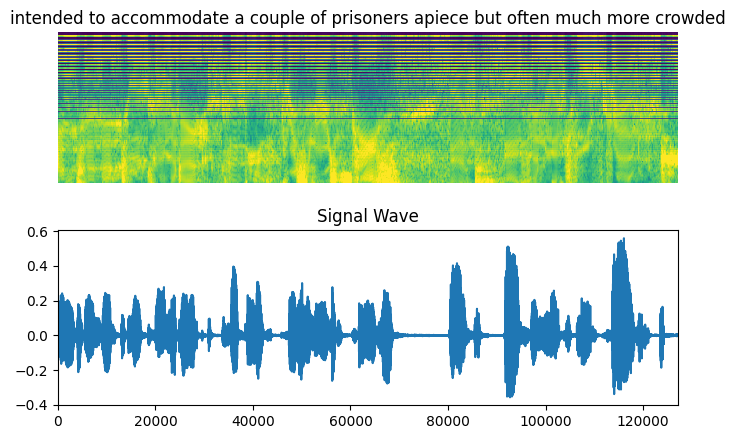

In [30]:
fig = plt.figure(figsize=(8,5))
for batch in train_dataset.take(1):
  spectrogram = batch[0][0].numpy()
  spectrogram = np.array([np.trim_zeros(x) for x in np.transpose(spectrogram)])
  label = batch[1][0]
  # Spectrogram
  label = tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8")
  ax = plt.subplot(2, 1, 1)
  ax.imshow(spectrogram, vmax=1)
  ax.set_title(label)
  ax.axis("off")
  # WAV
  file = tf.io.read_file("/kaggle/working/wavs/" + list(df_train["file_name"])[0]+ ".wav")
  audio,_ = tf.audio.decode_wav(file)
  audio = audio.numpy()
  ax = plt.subplot(2, 1, 2)
  plt.plot(audio)
  ax.set_title("Signal Wave")
  ax.set_xlim(0, len(audio))
  display.display(display.Audio(np.transpose(audio), rate = 16000))
plt.show()

## Model Creation

In [31]:
def CTCLoss(y_true, y_pred):
  batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
  input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
  label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

  input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
  label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

  loss = keras.backend.ctc_batch_cost(y_true, y_pred, input_length, label_length)
  return loss

In [32]:
def build_model(input_dim, output_dim, rnn_layers=7, rnn_units=128):
  input_spectogram = layers.Input((None, input_dim))
  x = layers.Reshape((-1, input_dim, 1), name="expand_dim")(input_spectogram)
  # Convlutional layer 1
  x = layers.Conv2D(
      filters=32,
      kernel_size=[11, 41],
      strides=[2,2],
      padding="same",
      use_bias=False,
      name="conv_1",
  )(x)
  x = layers.BatchNormalization(name="conv_1_bn")(x)
  x = layers.ReLU(name="conv_1_relu")(x)
  # Convlutional layer 2
  x = layers.Conv2D(
      filters=32,
      kernel_size=[11, 21],
      strides=[1,2],
      padding="same",
      use_bias=False,
      name="conv_2",
  )(x)
  x = layers.BatchNormalization(name="conv_2_bn")(x)
  x = layers.ReLU(name="conv_2_relu")(x)
  # Convlutional layer 3
  x = layers.Conv2D(
      filters=64,
      kernel_size=[11, 21],
      strides=[1,2],
      padding="same",
      use_bias=False,
      name="conv_3",
  )(x)
  x = layers.BatchNormalization(name="conv_3_bn")(x)
  x = layers.ReLU(name="conv_3_relu")(x)
  x = layers.Reshape((-1, x.shape[-2] * x.shape[-1]))(x)
  # RNN Layer
  for i in range(1, rnn_layers + 1):
    recurrent = layers.GRU(
        units=rnn_units,
        activation="tanh",
        recurrent_activation="sigmoid",
        use_bias=True,
        return_sequences=True,
        reset_after=True,
        name=f"gru_{i}",
    )
    x = layers.Bidirectional(recurrent, name=f"bidirectional_{i}", merge_mode="concat")(x)
    if i < rnn_layers:
      x = layers.Dropout(rate=0.5)(x)
  # Dense Layer
  x = layers.Dense(units=rnn_units * 2, name="dense_1")(x)
  x = layers.ReLU(name="dense_1_relu")(x)
  x = layers.Dropout(rate=0.5)(x)
  # classification layer
  output = layers.Dense(units=output_dim + 1, activation="softmax", name="output")(x)
  # model
  model = keras.Model(input_spectogram, output, name="DeepSpeech2")
  # optimizer
  opt = keras.optimizers.Adam(learning_rate=1e-4)
  # compile the model and return
  model.compile(optimizer=opt, loss=CTCLoss)
  return model

model = build_model(
    input_dim=fft_length // 2 + 1,
    output_dim=char_to_num.vocabulary_size(),
    rnn_units=512,
)
model.summary(line_length=110)

Model: "DeepSpeech2"
______________________________________________________________________________________________________________
 Layer (type)                                    Output Shape                                Param #          
 input_1 (InputLayer)                            [(None, None, 193)]                         0                
                                                                                                              
 expand_dim (Reshape)                            (None, None, 193, 1)                        0                
                                                                                                              
 conv_1 (Conv2D)                                 (None, None, 97, 32)                        14432            
                                                                                                              
 conv_1_bn (BatchNormalization)                  (None, None, 97, 32)                      

In [33]:
# A utility function to decode the output of the network
def decode_batch_prediction(pred):
  input_len = np.ones(pred.shape[0]) * pred.shape[1]
  # bisa pakai beam search juga --> untuk complex tasks
  results = keras.backend.ctc_decode(pred, input_length=input_len, greedy=True)[0][0]
  # iterate over the results and get back the text
  output_text = []
  for result in results:
    result = tf.strings.reduce_join(num_to_char(result)).numpy().decode("utf-8")
    output_text.append(result)
  return output_text

# A callback class to output a few transcriptions during training
class CallbackEval(keras.callbacks.Callback):
  def __init__(self, dataset):
    super().__init__()
    self.dataset = dataset

  def on_epoch_end(self, epoch: int, logs=None):
    predictions = []
    targets = []
    for batch in self.dataset:
      x, y = batch
      batch_predictions = model.predict(x)
      batch_predictions = decode_batch_prediction(batch_predictions)
      predictions.extend(batch_predictions)
      for label in y:
        label = (
            tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8")
        )
        targets.append(label)
    wer_score = wer(targets, predictions)
    print("-" * 100)
    print(f"Word Error Rate: {wer_score:.4f}")
    print("-" * 100)
    for i in np.random.randint(0, len(predictions), 2):
      print(f"Target    : {targets[i]}")
      print(f"Prediction: {predictions[i]}")
      print("-" * 100)

In [34]:
# Specify the path where you want to save the model
checkpoint_filepath = '/kaggle/working/checkpoint.weights.h5'

# Create a ModelCheckpoint callback
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='loss',
    mode='min',
    save_best_only=True)

## Model Training

In [ ]:
epochs = 500
validation_callback = CallbackEval(validation_dataset)

if os.path.exists(checkpoint_filepath):
    model.load_weights(checkpoint_filepath)
    print("Loaded weights from checkpoint")
else:
    print("No checkpoint found. Starting from scratch.")

history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=epochs,
    callbacks=[validation_callback, model_checkpoint_callback],
)

In [ ]:
saved_model_path = "/kaggle/working/capstone_model_new_greedy.h5"
model.save(saved_model_path)